# Example

This notebook demonstrates:
* Training assay models
* Training confidence models and assigning confidence levels
* Measuring confidence level accuracy

In the absence of publicly available timestamped data, we assign arbitrary assay dates to a dataset from SIMPD (https://doi.org/10.1186/s13321-023-00787-9).

In [1]:
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from tqdm import tqdm

from ocla.calibration import Calibration, get_global_calibration_data
from ocla.confidence import CONFIDENCE_THRESHOLDS, ModelConfidence
from ocla.models import Model, ModelType
from ocla.utilities import Transform, get_training_dates

INFO:rdkit:Enabling RDKit 2024.03.5 jupyter extensions


In [2]:
CONFIDENCE_LEVELS = [item.name for item in list(ModelConfidence)]
LOG_THRESHOLDS = np.log10(CONFIDENCE_THRESHOLDS)
COLORS = [
    (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
    (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
    (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
    (0.8, 0.47058823529411764, 0.7372549019607844),
]
CALIBRATION_LEVELS = [Calibration.UNDERCONFIDENT.name, Calibration.CORRECT.name, Calibration.OVERCONFIDENT.name]
CALIBRATION_COLORS = [
    (0.9254901960784314, 0.8823529411764706, 0.2),
    (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
    (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
]

In [3]:
MODEL_TYPE = ModelType.GAUSSIAN_PROCESS
NUM_SPLITS = 10
# Dopamine D2 receptor dataset.
URL = "https://github.com/rinikerlab/molecular_time_series/raw/403f758faa73ec451ce73391d4ce5ebe292825a8/datasets/source_data/target_CHEMBL217-1.csv.gz"

## Load data and assign arbitrary assay dates

In [4]:
raw_data = pd.read_csv(URL)
print(raw_data.shape)
raw_data.sample(5)

(996, 3)


,canonical_smiles,compound_chembl_id,pchembl_value
944,O=C1N(CCN2C[C@H]3CC[C@H](CC3)C2)CCN1c1cccc(Cl)c1,CHEMBL565075,7.60
73,COc1ccccc1N1CCN(CCCCCNC(=O)c2cc3ccccn3n2)CC1,CHEMBL140968,7.15
486,Nc1ccc2c(c1)C(O)C(CCN1CCC(C(=O)c3ccc(F)cc3O)CC...,CHEMBL3104523,6.19
168,Cc1cn(CCCCN2CCN(c3cc(C(F)(F)F)nc(C(C)(C)C)n3)C...,CHEMBL201115,6.50
933,CN(CCN1CCN(c2ccc(F)cc2)C1=O)C[C@]12CC[C@H](CC1...,CHEMBL562836,6.20


In [5]:
# Assign arbitrary dates; divide the data into chunks and assign each chunk a different week.
renames = {"canonical_smiles": "smiles", "compound_chembl_id": "mol_id", "pchembl_value": "label"}
data = []
current_date = datetime.date(2023, 1, 1)
for df in np.array_split(raw_data.rename(columns=renames).sort_values("mol_id"), NUM_SPLITS):
    df["assay_date"] = current_date
    current_date += datetime.timedelta(weeks=1)
    data.append(df)
data = pd.concat(data, ignore_index=True)
data["assay_date"] = pd.to_datetime(data["assay_date"])
assert len(data) == len(raw_data)
data.sample(5)

/Users/skearnes/miniconda3/envs/ocla/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,smiles,mol_id,label,assay_date
557,O=C(NC/C=C/CN1CCN(c2cccc(Cl)c2Cl)CC1)c1cc2cccc...,CHEMBL366904,7.12,2023-02-05
609,Clc1cccc(N2CCN(CCCCOc3ccc(-c4cn5ccccc5n4)cc3)C...,CHEMBL387784,7.17,2023-02-12
675,Cc1cc(C)n(C2CN(CCCc3nc(-c4ccccc4)no3)C2)n1,CHEMBL4169603,5.25,2023-02-12
452,CO[C@@]1(C)c2cccc3c2-c2c1ccc1c2[C@@H](C3)N(C)CC1,CHEMBL281923,7.15,2023-01-29
533,Cc1cccc(N2CCN(CCCCNC(=O)[C@H]3CCc4ccccc4N3)CC2)c1,CHEMBL3358506,5.47,2023-02-05


In [6]:
data["assay_date"].value_counts()

assay_date
2023-01-01    100
2023-01-08    100
2023-01-15    100
2023-01-22    100
2023-01-29    100
2023-02-05    100
2023-02-12     99
2023-02-19     99
2023-02-26     99
2023-03-05     99
Name: count, dtype: int64

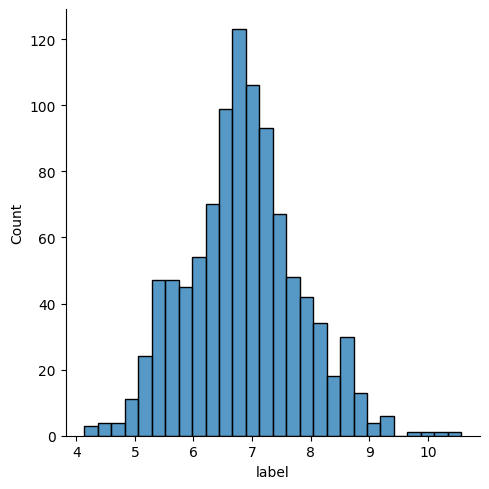

In [7]:
sns.displot(data["label"])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


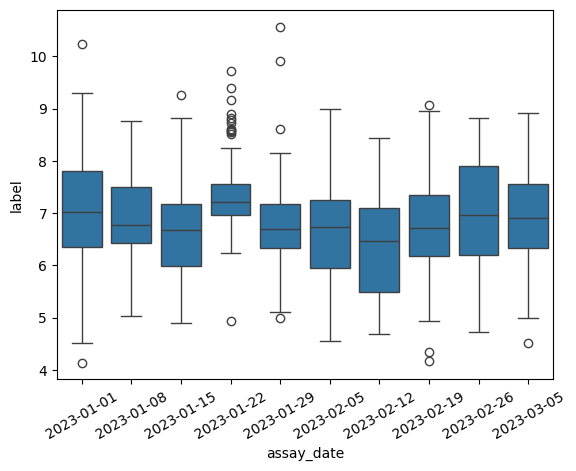

In [8]:
ax = sns.boxplot(data, x="assay_date", y="label")
ax.tick_params(axis="x", rotation=30)

## Train models and measure calibration

In [9]:
def get_calibration_data(
    data: pd.DataFrame, model_date: datetime.date, model_type: ModelType, confidence_transform: Transform
) -> dict[str, pd.DataFrame] | None:
    """Computes calibration data for a single model date."""
    mask = data["assay_date"].dt.date <= model_date
    if mask.sum() == len(data):
        return None
    model = Model(model_type=model_type)
    model.train(data[mask], confidence_transform=confidence_transform)
    cv_data = model.cv_data
    cv_data["model_date"] = model_date
    confidence_weights = model.confidence_weights
    confidence_weights["model_date"] = model_date
    calibration_data = model.calibrate(data[~mask])
    calibration_data["model_date"] = model_date
    return {"cv_data": cv_data, "confidence_weights": confidence_weights, "calibration_data": calibration_data}

In [10]:
# Train models and get calibration statistics.
results = defaultdict(list)
for model_date in tqdm(get_training_dates(data["assay_date"])):
    result = get_calibration_data(
        data, model_date=model_date, model_type=MODEL_TYPE, confidence_transform=Transform.LOG
    )
    if result is None:
        continue
    for key, value in result.items():
        results[key].append(value)
cv_data = pd.concat(results["cv_data"], ignore_index=True)
confidence_weights = pd.concat(results["confidence_weights"], ignore_index=True)
calibration_data = pd.concat(results["calibration_data"], ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.86s/it]


### Cross-validation performance

In [11]:
print(cv_data.shape)
cv_data.sample(5)

(4494, 8)


,fold,mol_index,mol_id,smiles,label,location,scale,model_date
626,0,309,CHEMBL228606,COc1ccc(S(=O)(=O)N[C@H]2CC[C@H](N3CCC(c4ccccc4...,6.55,7.169856,0.455687,2023-01-22
4406,9,19,CHEMBL119455,CN1CCc2cccc3c2[C@H]1Cc1cccc(O)c1-3,7.23,6.977738,0.429966,2023-02-26
886,7,54,CHEMBL129757,Fc1ccc(OCCCNCCOc2ccc(Cl)cc2)cc1,6.61,6.569959,0.402362,2023-01-22
152,2,118,CHEMBL183776,COc1ccccc1N1CCN(CCc2ccc3[nH]nnc3c2)CC1,8.27,7.097751,0.580759,2023-01-08
3177,4,578,CHEMBL377200,Cc1c(CN2CCN(c3ccccc3)CC2)cnn1-c1ccccc1,6.20,6.003438,0.680233,2023-02-19


In [12]:
rows = []
for (model_date, fold), df in cv_data.groupby(["model_date", "fold"]):
    rows.append(
        {
            "model_date": model_date,
            "fold": fold,
            "r2_score": r2_score(df["label"], df["location"]),
            "mae": mean_absolute_error(df["label"], df["location"]),
        }
    )
cv_metrics = pd.DataFrame(rows)
print(cv_metrics.shape)
cv_metrics.head()

(90, 4)


,model_date,fold,r2_score,mae
0,2023-01-01,0,0.274293,0.762519
1,2023-01-01,1,0.845410,0.466787
2,2023-01-01,2,0.546782,0.841734
3,2023-01-01,3,0.049599,0.552885
4,2023-01-01,4,-0.165674,0.762946


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


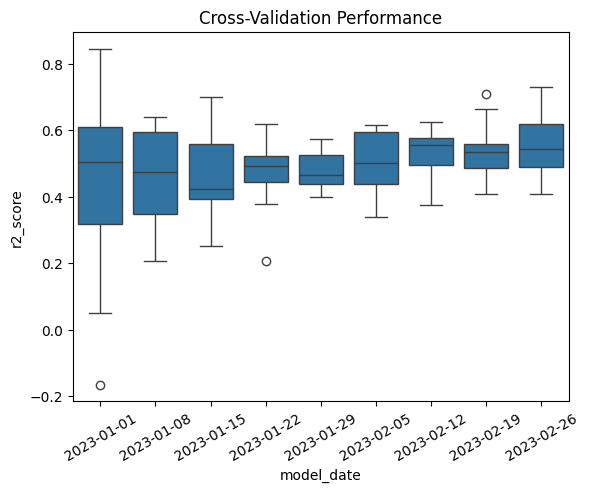

In [13]:
ax = sns.boxplot(cv_metrics, x="model_date", y="r2_score")
ax.set_title("Cross-Validation Performance")
ax.tick_params(axis="x", rotation=30)

### Confidence model parameters

In [14]:
confidence_weights.sample(5)

,threshold,u_location,u_scale,s_location,s_scale,w_location,w_scale,intercept,model_date
3,1.5,6.997744,0.509749,0.729963,0.193691,-0.014777,-0.177511,-1.160701,2023-01-08
19,3.0,6.839254,0.411184,0.757155,0.218812,-0.297598,-0.530419,0.530622,2023-02-12
7,3.0,6.863339,0.490256,0.726337,0.187271,-0.227123,-0.557833,0.338824,2023-01-15
23,10.0,6.841363,0.399809,0.762997,0.213510,-0.425537,-0.882869,2.442350,2023-02-19
11,10.0,6.988398,0.422752,0.740676,0.207117,-0.305947,-0.966475,2.462649,2023-01-22


Text(0, 0.5, '')

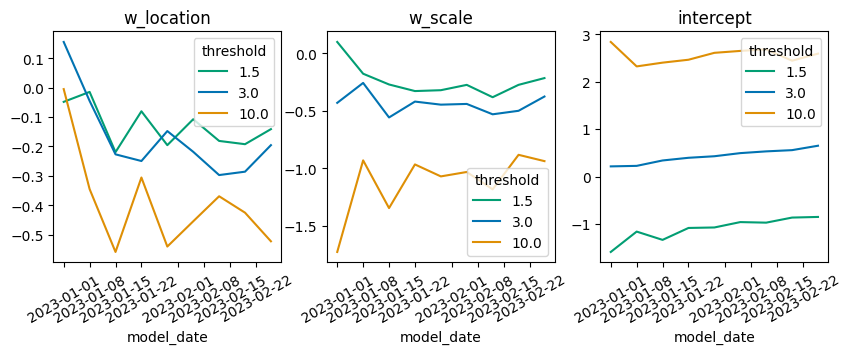

In [15]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=3)

sns.lineplot(confidence_weights, x="model_date", y="w_location", hue="threshold", palette=COLORS[:3], ax=axes[0])
axes[0].set_title("w_location")
axes[0].tick_params(axis="x", rotation=30)
axes[0].set_ylabel(None)

sns.lineplot(confidence_weights, x="model_date", y="w_scale", hue="threshold", palette=COLORS[:3], ax=axes[1])
axes[1].set_title("w_scale")
axes[1].tick_params(axis="x", rotation=30)
axes[1].set_ylabel(None)

sns.lineplot(confidence_weights, x="model_date", y="intercept", hue="threshold", palette=COLORS[:3], ax=axes[2])
axes[2].set_title("intercept")
axes[2].tick_params(axis="x", rotation=30)
axes[2].set_ylabel(None)

### Confidence level calibration

In [16]:
# Reduce model predictions to the "global" set with a single prediction for each compound.
# Use a calibration gap of zero weeks since the assay dates are arbitrary for this dataset.
calibration_data["model_date"] = pd.to_datetime(calibration_data["model_date"])
global_data = get_global_calibration_data(calibration_data, delta=datetime.timedelta(weeks=0))
print(global_data.shape)
global_data.sample(5)

(896, 16)


,smiles,mol_id,label,assay_date,normalized_smiles,location,scale,p(within 1.5x),p(within 3x),p(within 10x),confidence_level,transform,confidence_level_best_case,confidence_level_calibration,model_date,max_prediction_date
99,COc1cc2c(cc1OC)N(CCCCN1CCN(c3cc(C(F)(F)F)nc(C(...,CHEMBL203471,6.33,2023-01-08,COc1cc2c(cc1OC)N(CCCCN1CCN(c3cc(C(F)(F)F)nc(C(...,7.064961,1.045010,0.192046,0.387878,0.531362,D,LOG,C,UNDERCONFIDENT,2023-01-01,2023-01-08
1741,Cc1ccn2cc(-c3ccc(OCCCN4CCN(c5cccc(Cl)c5Cl)CC4)...,CHEMBL231079,7.08,2023-01-22,Cc1ccn2cc(-c3ccc(OCCCN4CCN(c5cccc(Cl)c5Cl)CC4)...,7.273653,0.742178,0.138964,0.368213,0.568241,D,LOG,B,UNDERCONFIDENT,2023-01-15,2023-01-22
3576,COc1cccc(OC)c1C(=O)NN1c2ccc(Cl)cc2N=C(N2CCN(C)...,CHEMBL425069,6.47,2023-02-12,COc1cccc(OC)c1C(=O)NN1c2ccc(Cl)cc2N=C(N2CCN(C)...,6.605814,0.444704,0.279753,0.630883,0.938436,C,LOG,A,UNDERCONFIDENT,2023-02-05,2023-02-12
3551,CN1CCN(CCCNC(=O)c2cc(=O)c3ccccc3[nH]2)CC1,CHEMBL4166411,5.43,2023-02-12,CN1CCN(CCCNC(=O)c2cc(=O)c3ccccc3[nH]2)CC1,6.524522,0.673863,0.221186,0.509689,0.825213,C,LOG,D,OVERCONFIDENT,2023-02-05,2023-02-12
1746,Cc1ccc2nc(-c3ccc(OCCCCN4CCN(c5cccc(Cl)c5Cl)CC4...,CHEMBL231183,6.83,2023-01-22,Cc1ccc2nc(-c3ccc(OCCCCN4CCN(c5cccc(Cl)c5Cl)CC4...,7.449868,0.724645,0.135658,0.367544,0.565878,D,LOG,C,UNDERCONFIDENT,2023-01-15,2023-01-22


In [17]:
print("Time-split validation")
print("R2", r2_score(global_data["label"], global_data["location"]))
print("MAE", mean_absolute_error(global_data["label"], global_data["location"]))

Time-split validation
R2 0.210921079852892
MAE 0.6437075709196798


In [18]:
global_data["confidence_level"].value_counts()

confidence_level
D    471
C    405
B     20
Name: count, dtype: int64

In [19]:
global_data["confidence_level_calibration"].value_counts()

confidence_level_calibration
UNDERCONFIDENT    576
CORRECT           246
OVERCONFIDENT      74
Name: count, dtype: int64

In [20]:
accurate = global_data["confidence_level_calibration"].isin([Calibration.UNDERCONFIDENT.name, Calibration.CORRECT.name])
print("Accuracy:", f"{accurate.sum() / len(global_data):.2%}")

Accuracy: 91.74%


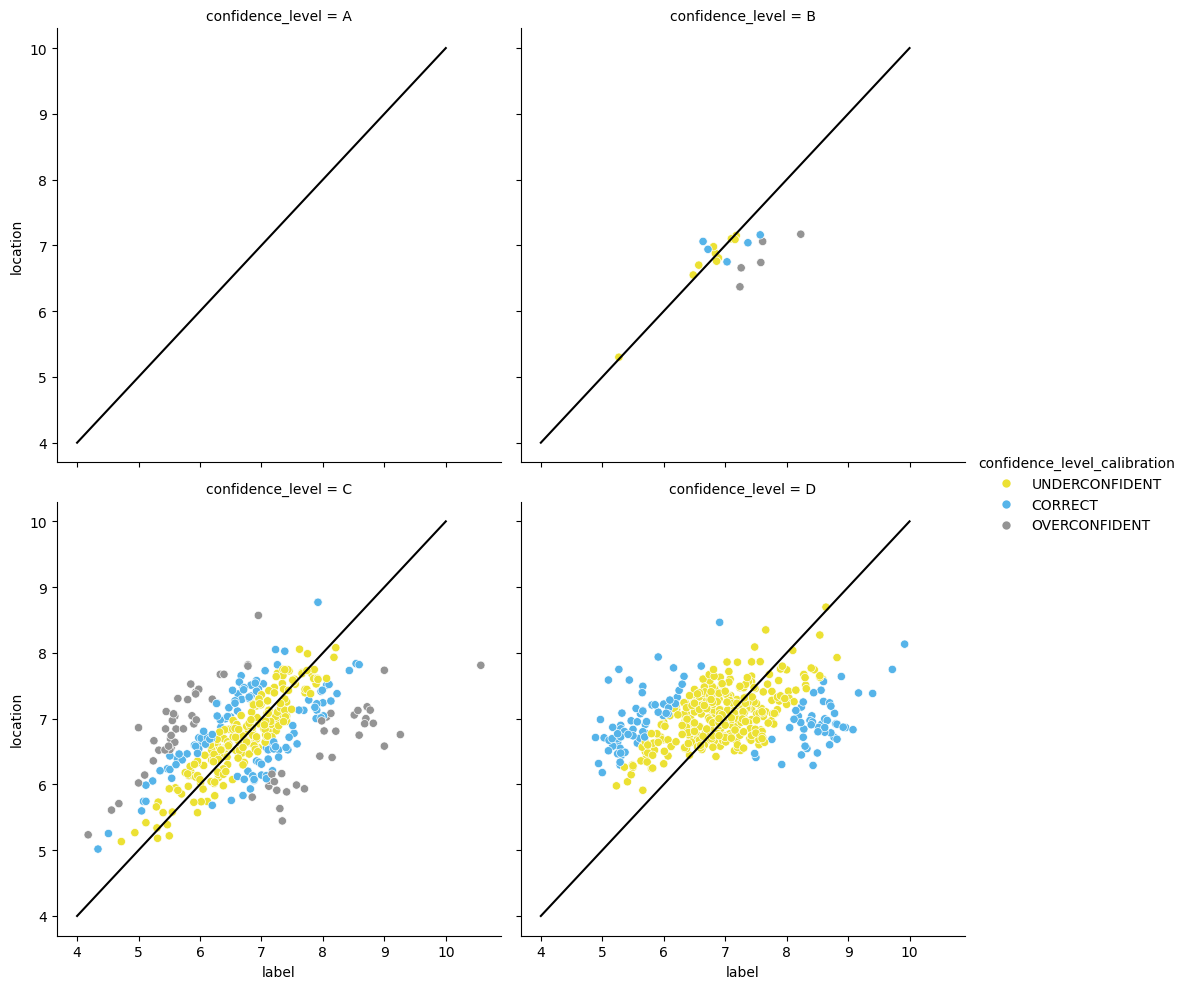

In [21]:
fig = sns.relplot(
    global_data,
    x="label",
    y="location",
    col="confidence_level",
    col_order=CONFIDENCE_LEVELS,
    col_wrap=2,
    hue="confidence_level_calibration",
    hue_order=CALIBRATION_LEVELS,
    palette=CALIBRATION_COLORS,
)
for ax in fig.axes:
    _ = ax.plot([4, 10], [4, 10], color="black")